# LSTM decoding exploration

Going to be looking at using LSTMs (with potentially some changes to the cost function) to decode EMGs from cortical data. This is all based off work from Steph and Josh.


Going to start with the old Jango data, then update from there as necessary.

In [5]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
# import ipympl

# we'll use ridge regression as a comparisson
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

from tkinter import Tk
from tkinter import filedialog as fd # just so I don't have to repeatedly manually enter filenames

# and tf stuff
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K # this was in Josh's version. Not sure why can't use numpy

In [6]:
# %matplotlib inline
import ipympl
# %matplotlib 

In [7]:
tf.config.list_physical_devices('GPU')

2022-09-14 11:33:13.037740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 11:33:13.038204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 11:33:13.038635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.038710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.038766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

[]

uld not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.038876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.038930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.038986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2022-09-14 11:33:13.039039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared o

### Import data

In [41]:
# request the filename
root = Tk()
mat_fn = fd.askopenfilename(master=root,filetypes=[('matlab data','*.mat')])
root.destroy()

Different loading code if it's data from Josh vs XDS stuff

**Josh**
It looks like this will input a dictionary containing (among other things) numpy arrays for each of the datasets for the day. We'll pull in each of them, and parse accordingly.

In the "binned" numpy arrays (two levels down), the organization seems to be:

0. timestamps
1. metadata
2. EMG names
3. EMG data
4. Force names
5. Force data
6. electrode and unit number
7. channel and unit number
8. Firing Rates (in hz)
9. Kin (cursor kin?) names
10. Kin (cursor kin?) data
11. Vel Data
12. Vel Names
13. Accel Data
14. Accel Names
15. Digital Words and timestamps
16. Targets:

    0. corner locations and appearance time 
    1. rotations and appearance time

17. Trial table data
18. Trial Table Labels
19. 
20. 
21. 

In [42]:
# load it in
data = loadmat(mat_fn)


In [10]:
def load_josh_mat(curr_data):
    timestamps = curr_data[0][0][0].reshape(-1)
    # create a couple of pandas data frames -- this will make things a bit easier

    # EMG
    emg_names = [curr_data[0][0][2][ii][0][0] for ii in np.arange(len(curr_data[0][0][2]))]
    EMG = pd.DataFrame(curr_data[0][0][3], columns=emg_names, index=timestamps)

    # Forces
    force_names = [curr_data[0][0][4][ii][0][0] for ii in np.arange(len(curr_data[0][0][4]))]
    force = pd.DataFrame(curr_data[0][0][5], columns=force_names, index=timestamps)

    # Firing Rates
    channel_names = [f"cc{row[0]:03d}ee{row[1]}" for row in curr_data[0][0][7]]
    firing = pd.DataFrame(curr_data[0][0][8], columns=channel_names, index=timestamps)

    # Kin -- not sure if cursor or ang of wrist. Will need to check
    kin_names = curr_data[0][0][9]
    vel_names = curr_data[0][0][12]
    acc_names = curr_data[0][0][14]
    kin = pd.DataFrame(curr_data[0][0][10], columns=kin_names, index=timestamps)
    try:
        kin = kin.join(pd.DataFrame(curr_data[0][0][11], columns=vel_names, index=timestamps))
        kin = kin.join(pd.DataFrame(curr_data[0][0][13], columns=acc_names, index=timestamps))
    except:
        pass

    # trial table
    trial_names = curr_data[0][0][18]
    trial_table = pd.DataFrame(curr_data[0][0][17], columns=trial_names)

    return timestamps, firing, EMG, force, kin


#### DoneText
A quick script that will send me a text message when I ask it to -- so that I can walk away and work on other things

In [ ]:

import smtplib
import ssl
from os import getenv

# To send a text when you've finished everything
class doneText():
    def __init__(self):
        self.notif_email = getenv('notif_email') # source for this email
        self.notif_pass = getenv('notif_pass')   # pass for the source email
        self.notif_target = getenv('notif_target') # target email [phone_num]@[mmsgateway]

    def send(self, message):
        ssl_context = ssl.create_default_context()
        with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=ssl_context) as server:
            server.login(self.notif_email, self.notif_pass)
            result = server.sendmail(self.notif_email, self.notif_target, f"Subject:\n{message}")

            print(f"Text send result: {result}")
            server.quit()


dntxt = doneText() # initialize an instance

In [ ]:
import winsound

def doneTone():
    low_A = 440
    # C_sharp = int(440* 2**(4/12))
    # E = int(440* 2**(7/12))
    # hi_A = int(440* 2)

    winsound.Beep(low_A, 500)
    # winsound.Beep(E, 500)
    # winsound.Beep(C_sharp, 500)
    # winsound.Beep(hi_A, 1500)



## Summarize the data

Plot out some good information on the max and variances of each muscle. Should also look at something for the cortex, maybe depth of modulation or avg firing rates?

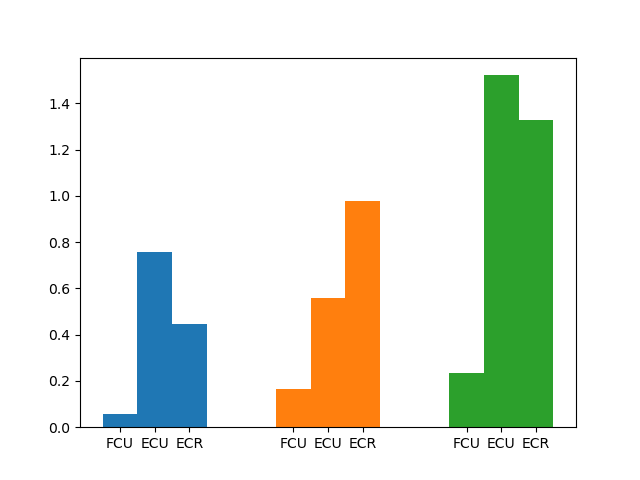

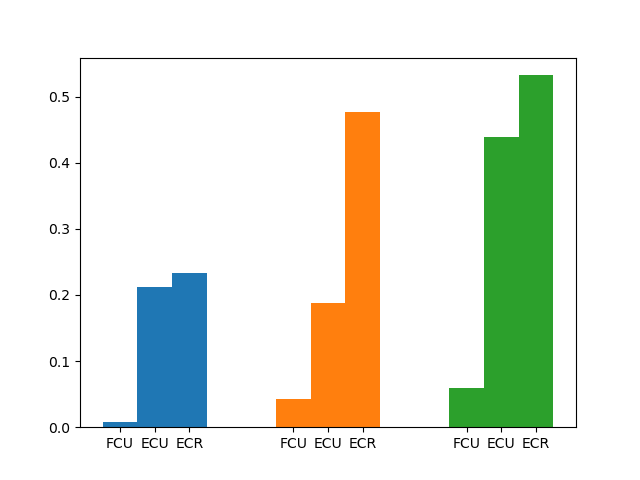

In [43]:
train_names = ['WmTrain','SprTrain','IsoTrain']
test_names = ['WmTest','SprTest','IsoTest']

_, WmTrain_firing, WmTrain_EMG, _, _ = load_josh_mat(data['WmTrain'])
_, WmTest_firing, WmTest_EMG, _, _ = load_josh_mat(data['WmTest'])
_, IsoTrain_firing, IsoTrain_EMG, _, _ = load_josh_mat(data['IsoTrain'])
_, IsoTest_firing, IsoTest_EMG, _, _ = load_josh_mat(data['IsoTest'])
_, SprTrain_firing, SprTrain_EMG, _, _ = load_josh_mat(data['SprTrain'])
_, SprTest_firing, SprTest_EMG, _, _ = load_josh_mat(data['SprTest'])


# --------------------------------------------
# Max EMG values bar plot

fig_emg_max, ax_emg_max = plt.subplots()
i_muscles = np.arange(WmTrain_EMG.shape[1]) # indexing on the x axis
bar_width = .2


ax_emg_max.bar(i_muscles*bar_width, np.max(WmTrain_EMG,axis=0), width = bar_width, label='Movement')
ax_emg_max.bar(i_muscles*bar_width + 1, np.max(IsoTrain_EMG, axis=0), width = bar_width, label='Isometric')
ax_emg_max.bar(i_muscles*bar_width + 2, np.max(SprTrain_EMG, axis=0), width = bar_width, label='Spring')

ax_emg_max.set_xticks(np.concatenate([i_muscles*bar_width, i_muscles*bar_width+1, i_muscles*bar_width+2]))
ax_emg_max.set_xticklabels(np.concatenate([WmTrain_EMG.columns, IsoTrain_EMG.columns, SprTrain_EMG.columns]))

fig_emg_max.show()
_ = ax_emg_max.legend()

ax_emg_max.set_xlabel('Muscle')
ax_emg_max.set_ylabel('Max Value')

# For each bar in the chart, add a text label.
for bar in ax_emg_max.patches:
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:.02f}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax_emg_max.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)
    
# --------------------------------------------
# 95th percentile
fig_emg_max, ax_emg_max = plt.subplots()
i_muscles = np.arange(WmTrain_EMG.shape[1]) # indexing on the x axis
bar_width = .2


ax_emg_max.bar(i_muscles*bar_width, np.percentile(WmTrain_EMG, 95,axis=0), width = bar_width, label='Movement')
ax_emg_max.bar(i_muscles*bar_width + 1, np.percentile(IsoTrain_EMG, 95, axis=0), width = bar_width, label='Isometric')
ax_emg_max.bar(i_muscles*bar_width + 2, np.percentile(SprTrain_EMG, 95, axis=0), width = bar_width, label='Spring')

ax_emg_max.set_xticks(np.concatenate([i_muscles*bar_width, i_muscles*bar_width+1, i_muscles*bar_width+2]))
ax_emg_max.set_xticklabels(np.concatenate([WmTrain_EMG.columns, IsoTrain_EMG.columns, SprTrain_EMG.columns]))

fig_emg_max.show()
_ = ax_emg_max.legend()

ax_emg_max.set_xlabel('Muscle')
ax_emg_max.set_ylabel('95th Percentile')

# For each bar in the chart, add a text label.
for bar in ax_emg_max.patches:
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:.02f}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax_emg_max.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)
    


## Model building 
Look through a couple of different model types, look to see how they are trained


### Linear with Static Non-linearity

Using the lab default -- build a wiener filter, fit it, then fit with a static polynomial on top of the form

$Ax^2 + Bx + C$

Where $x$ is the original EMG prediction, and the output is the new EMG prediction

Alternatively, I have also allowed to predict using an exponential activation 

$Ae^{Bx} + C$

Also giving the options for a sigmoid


**Starting with defining our nonlinearity methods**

In [ ]:
# using scipy's least_squares:
def non_linearity(p, y_pred, nonlinear_type):
    if nonlinear_type == 'poly':
        return p[0] + p[1]*y_pred + p[2]*y_pred**2
    elif nonlinear_type == 'exponential':
        return p[0]*np.exp(p[1]*y_pred) + p[2]
    elif nonlinear_type == 'sigmoid':
        return p[1] * 1/(1 + np.exp(-10*(y_pred-p[0])))

def non_linearity_residuals(p, y_pred, y_act, nonlinear_type):
    if nonlinear_type == 'poly':
        return y_act - (p[0] + p[1]*y_pred + p[2]*y_pred**2)
    elif nonlinear_type == 'exponential':
        return y_act - (p[0]*np.exp(p[1]*y_pred) + p[2])
    elif nonlinear_type == 'sigmoid':
        return y_act - (p[1] * 1/(1 + np.exp(-10*(y_pred-p[0]))))



Next a function that compares Wiener filter models with Wiener cascades, reports the VAF (Cooefficient of Determination) and gives plots for the validation predictions

In [ ]:
# Set up a function that we can just call multiple times, so then we can just quickly run through all of the different combinations


def basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type, save_plot=True):
    wiener_input = pd.DataFrame() # empty dataframe
    n_lags = 10 # number of lags
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(train_firing.columns, train_firing.columns+f"_lag{ii}"))
        wiener_input = wiener_input.join(train_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')

    wiener_test = pd.DataFrame() # empty dataframe
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(test_firing.columns, test_firing.columns+f"_lag{ii}"))
        wiener_test = wiener_test.join(test_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')
        
    wiener_retrain = pd.DataFrame() # empty dataframe
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(retrain_firing.columns, retrain_firing.columns+f"_lag{ii}"))
        wiener_retrain = wiener_retrain.join(retrain_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')



    if nonlinear_type == 'poly':
        init_pred = [.1, .1, .1]
    elif nonlinear_type == 'exponential':
        init_pred = [1, .1, .2]
    elif nonlinear_type == 'sigmoid':
        init_pred = [.1, .5]

    mdl_A = linear_model.LinearRegression(fit_intercept=True)
    mdl_B = {} # a dictionary of numpy polynomials. Probably a better way to do this, maybe Xuan's method... oh well

    mdl_A.fit(wiener_input, train_EMG)# fit the first model
    prefit_EMG = mdl_A.predict(wiener_input) # get the initially predicted EMGs
    retrain_pred = mdl_A.predict(wiener_retrain) # from a training set on a separate condition -- to properly hold out test data
    prefit_VAF = metrics.explained_variance_score(train_EMG, prefit_EMG, multioutput='raw_values')
    nonlin_EMG = np.zeros(prefit_EMG.shape)

    print('Training Results\n')

    for ii in np.arange(len(train_EMG.columns)):
        muscle = train_EMG.columns[ii]
        mdl_B[muscle] = least_squares(non_linearity_residuals, init_pred, args=(prefit_EMG[:,ii], train_EMG.iloc[:,ii].to_numpy(), nonlinear_type)).x
        # print('--------------------------------------------------------')
        print(muscle)
        print(f"\tLinear VAF: {prefit_VAF[ii]:.03f}")
        nonlin_EMG[:,ii] = non_linearity(mdl_B[muscle],(prefit_EMG[:,ii]), nonlinear_type)
        print(f"\tNonLinear VAF: {metrics.explained_variance_score(train_EMG.iloc[:,ii],nonlin_EMG[:,ii]):.03f}")




    # predicting the test set
    prefit_test = mdl_A.predict(wiener_test)
    prefit_test_VAF = metrics.explained_variance_score(test_EMG, prefit_test, multioutput='raw_values')
    nonlin_test = np.zeros(prefit_test.shape)
    nonlin_within_test = np.zeros(prefit_test.shape)
    nonlin_VAF = np.zeros(prefit_test_VAF.shape)
    nonlin_within_VAF = np.zeros(prefit_test_VAF.shape)
    mdl_C = {} # for a separate non-linearity, built for the second condition.

    print('\n------------------------------------------------------------\n')
    print('Testing Results\n')
    for ii in np.arange(len(train_EMG.columns)):
        muscle = test_EMG.columns[ii]
        mdl_C[muscle] = least_squares(non_linearity_residuals, init_pred, args=(retrain_pred[:,ii], retrain_EMG.iloc[:,ii].to_numpy(), nonlinear_type)).x
        # print('--------------------------------------------------------')
        print(muscle)
        print(f"\tLinear VAF: {prefit_test_VAF[ii]:.03f}")
        nonlin_test[:,ii] = non_linearity(mdl_B[muscle],(prefit_test[:,ii]), nonlinear_type)
        nonlin_within_test[:,ii] = non_linearity(mdl_C[muscle],(prefit_test[:,ii]), nonlinear_type)
        nonlin_VAF[ii] = metrics.explained_variance_score(test_EMG.iloc[:,ii],nonlin_test[:,ii])
        nonlin_within_VAF[ii] = metrics.explained_variance_score(test_EMG.iloc[:,ii],nonlin_within_test[:,ii])
        print(f"\tPre-built Nonlinearity VAF: {nonlin_VAF[ii]:.03f}")
        print(f"\tRe-built Nonlinearity VAF: {nonlin_within_VAF[ii]:.03f}")

    # Plotting the test data -- so that we can see how  the non-linearities act between types
    n_rows = int(np.ceil(np.sqrt(len(train_EMG.columns))))
    fig_nl_test, ax_nl_test = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

    for muscle_ii in np.arange(len(train_EMG.columns)):
        row_i = int(muscle_ii//n_rows)
        col_i = int(muscle_ii%n_rows)
        ax_nl_test[row_i,col_i].plot(test_timestamps, test_EMG.iloc[:,muscle_ii], label='Recorded')
        ax_nl_test[row_i,col_i].plot(test_timestamps,prefit_test[:,muscle_ii], label=f'Linear VAF: {prefit_test_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].plot(test_timestamps,nonlin_test[:,muscle_ii], label=f'NonLin VAF: {nonlin_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].plot(test_timestamps,nonlin_within_test[:,muscle_ii], label=f'Rebuilt NonLin VAF: {nonlin_within_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].set_title(f"{test_EMG.columns[muscle_ii]}")
        ax_nl_test[row_i,col_i].set_xlabel(f"Time (s)")
        ax_nl_test[row_i,col_i].set_ylabel("EMG envelope")
        
        _ = ax_nl_test[row_i,col_i].legend()

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_nl_test[row_i,col_i].spines[spine].set_visible(False)
            
    if save_plot:
        fig_nl_test.savefig('Wiener_Cascade_Comparison.svg')

    # let's also plot the VAFs in a clean manner so that it's easy to compare
    fig_vaf, ax_vaf = plt.subplots()
    i_muscles = np.arange(len(test_EMG.columns)) # indexing on the x axis
    bar_width = .25

    ax_vaf.bar(i_muscles, prefit_test_VAF, width = bar_width, label='Linear')
    ax_vaf.bar(i_muscles + bar_width, nonlin_VAF, width = bar_width, label='Nonlinear')
    ax_vaf.bar(i_muscles + 2*bar_width, nonlin_within_VAF, width = bar_width, label='Rebuilt Nonlinear')

    ax_vaf.set_xticks(i_muscles + 1*bar_width)
    ax_vaf.set_xticklabels(test_EMG.columns)

    ax_vaf.set_ylim([-.05, 1.05])
    ax_vaf.set_xlabel('Muscle')
    ax_vaf.set_ylabel('Coefficient of Determination')

    ax_vaf.legend()

    # For each bar in the chart, add a text label.
    for bar in ax_vaf.patches:
        # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:.02f}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        ax_vaf.spines[spine].set_visible(False)


    if save_plot:
        fig_vaf.savefig('Wiener_VAF.svg')

    return nonlin_EMG


In [ ]:
def LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps, plot=True, save_plot=True):
    # hyper params
    layer_0_units = 300
    drop_in = .25     # input dropout percentage for LSTM layer
    drop_rec = .15    # recurrent dropout for LSTM
    drop_lay = .15    # dropout layer?

    # # input hyper params -- reshape input vector
    # batch_size = 64 # why not? will test to see training accuracy after
    # seq_len = train_firing.shape[0]//batch_size # splitting out the batches
    n_neurons = train_firing.shape[1] # number of neurons
    n_EMGs = train_EMG.shape[1]
    seq_len = 12
    rnn_train_i = np.zeros((train_firing.shape[0],seq_len, train_firing.shape[1]))
    rnn_test_i = np.zeros((test_firing.shape[0],seq_len, test_firing.shape[1]))
    rnn_train_o = train_EMG.to_numpy()
    rnn_test_o = test_EMG.to_numpy()
    
    # normalize the EMGs
    EMG_std = np.std(rnn_train_o, axis=0)
    for ii in np.arange(rnn_train_o.shape[1]):
        rnn_train_o[:,ii] = rnn_train_o[:,ii]/EMG_std[ii]
        rnn_test_o[:,ii] = rnn_test_o[:,ii]/EMG_std[ii]
    
    # create the sequences
    for ii in np.arange(10):
        rnn_train_i[:,ii,:] = train_firing.shift(-ii, fill_value=0).to_numpy()
        rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()

    # Set up the LSTMs
    mdl = tf.keras.models.Sequential()


    mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
    if drop_lay:
        mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
#     mdl.add(tf.keras.layers.Dense(train_EMG.shape[1], activation='relu')) # dense combination layer
    mdl.add(tf.keras.layers.Dense(train_EMG.shape[1])) # dense combination layer
    mdl.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
    
    mdl.fit(rnn_train_i, rnn_train_o, epochs=20, verbose=False)
    
    
    train_pred = mdl.predict(rnn_train_i)
    test_pred = mdl.predict(rnn_test_i)
    train_VAFs = metrics.explained_variance_score(rnn_train_o, train_pred, multioutput='raw_values')
    test_VAFs = metrics.explained_variance_score(rnn_test_o, test_pred, multioutput='raw_values')
    
    print('----------------------------------------')
    for ii in np.arange(len(train_EMG.columns)):
        print(train_EMG.columns[ii])
        print(f"\tTrain VAF: {train_VAFs[ii]}")
        print(f"\tTest VAF: {test_VAFs[ii]}")
    
    
    # plottin
    
    if plot:
        n_rows = int(np.ceil(np.sqrt(len(train_EMG.columns))))
        fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

        for muscle_ii in np.arange(len(train_EMG.columns)):
            row_i = int(muscle_ii//n_rows)
            col_i = int(muscle_ii%n_rows)
            ax_lstm[row_i,col_i].plot(test_timestamps, test_EMG.iloc[:,muscle_ii]*EMG_std[ii], label='Recorded')
            ax_lstm[row_i,col_i].plot(test_timestamps,test_pred[:,muscle_ii]*EMG_std[ii], label=f'LSTM VAF: {test_VAFs[muscle_ii]:.03f}')
            ax_lstm[row_i,col_i].set_title(f"{test_EMG.columns[muscle_ii]}")
            _ = ax_lstm[row_i,col_i].legend()

            # turn off the spines
            for spine in ['right','top','bottom','left']:
                ax_lstm[row_i,col_i].spines[spine].set_visible(False)

        if save_plot:
            fig_lstm.savefig('LSTM_traces.svg')
                
                
        # let's also plot the VAFs in a clean manner so that it's easy to compare
        fig_vaf, ax_vaf = plt.subplots()
        i_muscles = np.arange(len(test_EMG.columns)) # indexing on the x axis
        bar_width = .3

        ax_vaf.bar(i_muscles, train_VAFs, width = bar_width, label='Train')
        ax_vaf.bar(i_muscles + bar_width, test_VAFs, width = bar_width, label='Test')

        ax_vaf.set_xticks(i_muscles + bar_width/2)
        ax_vaf.set_xticklabels(test_EMG.columns)

        ax_vaf.set_ylim([-.05, 1.05])
        ax_vaf.set_xlabel('Muscle')
        ax_vaf.set_ylabel('VAF')

        ax_vaf.legend()

        # For each bar in the chart, add a text label.
        for bar in ax_vaf.patches:
            # The text annotation for each bar should be its height.
            bar_value = bar.get_height()
            # Format the text with commas to separate thousands. You can do
            # any type of formatting here though.
            text = f'{bar_value:.02f}'
            # This will give the middle of each bar on the x-axis.
            text_x = bar.get_x() + bar.get_width() / 2
            # get_y() is where the bar starts so we add the height to it.
            text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
            # If we want the text to be the same color as the bar, we can
            # get the color like so:
            bar_color = bar.get_facecolor()
            # If you want a consistent color, you can just set it as a constant, e.g. #222222
            ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                    size=12)

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_vaf.spines[spine].set_visible(False)


        if save_plot:
            fig_vaf.savefig('LSTM_VAF.svg')


    return test_VAFs


### Define Custom Loss functions

First the weighted loss function. This one calculates the MSE, but weights the value for each point in time by the variance of that particular task. This balances the training so that the model is able to train for conditions with different EMG ranges (the whole idea behind our system...)

In [ ]:
# weight the losses by the std of that particular range in time and muscle.
# for hybrid decoders
def hybrid_weight_loss(target, pred):
    # inputs: 
    #         target is the recorded data, plus the weights since this needs to be callable by tf
    #                First half of the columns of the data will be EMG, second half will be the weights
    #         pred   is the current prediction values
    num_targets = K.shape(target)[1]//2 # number of cols / 2
    err = (target[:, 0:num_targets] - pred[:,0:num_targets]) # subtract the values
    se = K.square(err) * target[:,num_targets:] # multiply the square error by the gains
    mse = K.mean(se, axis=-1)
    return mse
    


Next is the variance Risk Extrapolation (V-REx) from Krueger et al 2021. The purpose of this is to maximize the out-of-distribution generalization. This places a penalty on the variance of the risk (MSE as defined...)

$ R_{V-REx}(\theta) = \beta * \sigma^2(R_1(\theta)....R_m(\theta)) + \sum_{e=1}^{m}R_e(\theta) $

Where risk is defined as 
 $ R = \sum_{i=0}^{I}\frac{\hat{y_i}-y_i}{I} $

In [11]:
# vREx loss function
def vrex_loss(target, pred):
    # from the Risk Extrapolation paper
    # B = 0 #
    # B = .5 #
    B = 1 #
    # B = 5 #
    # B = 10 #
    # B = 50 #
    # B = 100 #
    
    err = target[:,:-1] - pred[:,:-1] # without the condition flag
    se_musc = K.square(err) # squared error
    mse_musc = tf.expand_dims(K.mean(se_musc, axis=-1),-1) # mean squared error for each sample
    
    # now create a one-hot matrix for timestamps with a one for the appropriate condition
    conditions = target[:,-1] # condition flag
    u_conds,i_conds = tf.unique(conditions)
    cond_oh = tf.transpose(tf.one_hot(i_conds, len(u_conds))) # create a mask the same size as the risk
    
    # split up the risks (MSE for right now) per condition
    sum_risks = tf.matmul(cond_oh,mse_musc) # this gives us the per-condition sum of MSEs
    risks = tf.math.divide(sum_risks, K.sum(cond_oh, axis=1)) # and this should average them

    
    rex = B*K.var(risks) + K.sum(risks) # and now to run the risk extrapolation step

    return rex
    # return mse_musc
    

In [ ]:
def vrex_weighted(target, pred):
    # weighting the risks based on the var of the EMG
    # instead of using a one-hot matrix like above to keep track of the conditions,
    # we'll just use the passed variance values (since that will be different per-condition)

    # B = 0 #
    # B = .5 #
    # B = 1 #
    # B = 5 #
    # B = 10 #
    # B = 50 #
    B = 100 #
    
    err = target[:,:-1] - pred[:,:-1] # find the error
    se_musc = K.square(err) # square it
    mse_musc = tf.expand_dims(K.mean(SU_musc, axis=-1),-1) # expand dims so that it's (T,1) rather than (T,)
    
    # separate the conditions based on the passed variances
    var = target[:,-1] # last column
    u_var,i_var = tf.unique(conditions) # for another one-hot matrix
    var_oh = tf.transpose(tf.one_hot(i_conds, len(u_conds))) # variances
    
    weighted_risk = tf.matmul(cond_oh, mse_musc)
    
    

In [12]:
def LSTM_across_weighted(train_firing, train_EMG, test_firing, test_EMG, test_timestamps, plot=True):
    if type(train_firing) is not list:
        print(f"training data must be a list, not a {type(train_firing)}")
        return -1
    
    # hyper params
    layer_0_units = 300
    drop_in = .25     # input dropout percentage for LSTM layer
    drop_rec = .15    # recurrent dropout for LSTM
    drop_lay = .15    # dropout layer?
    
    # size and name of outputs
    n_target = train_EMG[0].shape[1] # dimensionality of target (EMGs usually)
    col_names = train_EMG[0].columns
    
    
    # put together the training targets 
    # This means both the EMGs and the variance for that portion of the training set
    loss_weights = np.ndarray((0,n_target)) # weights for the training losses
    rnn_train_o = np.ndarray((0,n_target*2)) # rnn target for training set. Going to also contain the weights
    rnn_test_o = test_EMG.to_numpy() # don't need the weights for the test set
    
    # initialize the input sequence data
    n_neurons = train_firing[0].shape[1] # number of neurons
    seq_len = 10
    rnn_train_i = np.ndarray((0,seq_len, n_neurons))
    rnn_test_i = np.ndarray((test_firing.shape[0], seq_len, n_neurons))
    
    # training target set
    for target in train_EMG:
        # put together the weights -- the variances, since we're doing MSE as our training loss
        temp_var = np.matmul(np.ones((target.shape[0],1)),np.var(target.to_numpy(), axis=0).reshape(1,-1))
#         loss_weights = np.append(loss_weights,temp_var, axis=0)
        # append the training targets
        temp_train = np.append(target.to_numpy(), 1./temp_var, axis=1)
        rnn_train_o = np.append(rnn_train_o, temp_train, axis=0)
    
    
    # testing target set -- have to append the neural firing
    for train in train_firing:
        temp_train_i = np.ndarray((train.shape[0], seq_len, n_neurons))
        for ii in np.arange(seq_len):
            temp_train_i[:,ii,:] = train.shift(-ii, fill_value=0).to_numpy()
        rnn_train_i = np.append(rnn_train_i, temp_train_i, axis=0)
            
    for ii in np.arange(seq_len):
        rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()
        
    
        # Set up the LSTMs
    mdl = tf.keras.models.Sequential()


    mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
    if drop_lay:
        mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
#     mdl.add(tf.keras.layers.Dense(n_target*2, activation='relu')) # dense combination layer -- x2 to account for weights
    mdl.add(tf.keras.layers.Dense(n_target*2)) # try with linear -- how does it compare?
    mdl.compile(loss=hybrid_weight_loss, optimizer='rmsprop', metrics=['MeanAbsoluteError'])
    
#     mdl.fit(rnn_train_i, rnn_train_o, epochs=20, batch_size=256, verbose=True)
    mdl.fit(rnn_train_i, rnn_train_o, epochs=40, verbose=False)
    
    
    train_pred = mdl.predict(rnn_train_i)[:,:n_target]
    test_pred = mdl.predict(rnn_test_i)[:,:n_target]
    train_VAFs = metrics.explained_variance_score(rnn_train_o[:,:n_target], train_pred, multioutput='raw_values')
    test_VAFs = metrics.explained_variance_score(rnn_test_o, test_pred, multioutput='raw_values')
    
    print('----------------------------------------')
    for ii in np.arange(n_target):
        print(col_names[ii])
        print(f"\tTrain VAF: {train_VAFs[ii]}")
        print(f"\tTest VAF: {test_VAFs[ii]}")
    
    if plot:
        # plottin
        n_rows = int(np.ceil(np.sqrt(n_target)))
        fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

        for muscle_ii in np.arange(n_target):
            row_i = int(muscle_ii//n_rows)
            col_i = int(muscle_ii%n_rows)
            ax_lstm[row_i,col_i].plot(test_timestamps, rnn_test_o[:,muscle_ii], label='Recorded')
            ax_lstm[row_i,col_i].plot(test_timestamps,test_pred[:,muscle_ii], label=f'LSTM VAF: {test_VAFs[muscle_ii]:.03f}')
            ax_lstm[row_i,col_i].set_title(f"{col_names[muscle_ii]}")
            _ = ax_lstm[row_i,col_i].legend()

            # turn off the spines
            for spine in ['right','top','bottom','left']:
                ax_lstm[row_i,col_i].spines[spine].set_visible(False)
    
    
        # let's also plot the VAFs in a clean manner so that it's easy to compare
        fig_vaf, ax_vaf = plt.subplots()
        i_muscles = np.arange(n_target) # indexing on the x axis
        bar_width = .3

        ax_vaf.bar(i_muscles, train_VAFs, width = bar_width, label='Train')
        ax_vaf.bar(i_muscles + bar_width, test_VAFs, width = bar_width, label='Test')

        ax_vaf.set_xticks(i_muscles + bar_width/2)
        ax_vaf.set_xticklabels(col_names)

        ax_vaf.set_ylim([-.05, 1.05])
        ax_vaf.set_xlabel('Muscle')
        ax_vaf.set_ylabel('VAF')

        ax_vaf.legend()

        # For each bar in the chart, add a text label.
        for bar in ax_vaf.patches:
            # The text annotation for each bar should be its height.
            bar_value = bar.get_height()
            # Format the text with commas to separate thousands. You can do
            # any type of formatting here though.
            text = f'{bar_value:.02f}'
            # This will give the middle of each bar on the x-axis.
            text_x = bar.get_x() + bar.get_width() / 2
            # get_y() is where the bar starts so we add the height to it.
            text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
            # If we want the text to be the same color as the bar, we can
            # get the color like so:
            bar_color = bar.get_facecolor()
            # If you want a consistent color, you can just set it as a constant, e.g. #222222
            ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                    size=12)

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_vaf.spines[spine].set_visible(False)

    

In [ ]:
# load tensorboard so that we can easily explore
# %load_ext tensorboard


def LSTM_grid_search(firing, EMG, n_iter = 150, n_fold = 10, n_epochs = 20, unit_range = [100, 400], drop_in_range = [0,.5], drop_rec_range = [0,.5], drop_lay_range = [0,.5], seq_range=[5,20], plot=True):
    # Runs a monte-carlo style grid search on hyper parameters
    # It will run mfxval, so there is no need for a separate training group
    #
    #  This will allow me to compare the number of lstm units, drop percentages,
    #  batch and sequence sizes, etc.
    
    EMG_names = EMG.columns
    cols = [f"{name}_train_VAF" for name in EMG_names]
    cols += [f'{name}_test_VAF' for name in EMG_names]
    cols += ['n_units','drop_in','drop_rec','drop_lay','seq_len']
    log = pd.DataFrame(columns=cols)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/LSTM_exploration', histogram_freq=1)

    
    n_neurons = firing.shape[1] # number of neurons
    n_EMGs = EMG.shape[1]
    
    # get the indices of the folds
    kf = KFold(n_splits=n_fold, random_state=None, shuffle=False) # working in chunks, not random indices
#     train_idx,test_idx = kf.split(firing) # get the indices. Won't split until later, since we will need to set up the sequences each round
    
    # intiialize the random number generator for the monte carlo
    rng = np.random.default_rng()
    
    for iter in np.arange(n_iter):
        layer_0_units = rng.integers(unit_range[0],unit_range[1])
        drop_in = rng.uniform(drop_in_range[0], drop_in_range[1])
        drop_rec = rng.uniform(drop_rec_range[0], drop_rec_range[1])
        drop_lay = rng.uniform(drop_lay_range[0], drop_lay_range[1])
        seq_len = rng.integers(seq_range[0], seq_range[1])
        
        rnn_i = np.ndarray((firing.shape[0], seq_len, firing.shape[1]))
        for ii in np.arange(seq_len):
            rnn_i[:,ii,:] = firing.shift(-ii, fill_value=0).to_numpy()
        
        
        train_VAFs = np.zeros((n_fold, n_EMGs))
        test_VAFs = np.zeros((n_fold, n_EMGs))
        
        log_entry = {'n_units':layer_0_units, 'drop_in':drop_in, 'drop_rec':drop_rec,\
                        'drop_lay':drop_lay, 'seq_len':seq_len}
        
        fold_idx = 0
        for train_idx,test_idx in kf.split(firing):

            rnn_train_i = np.zeros((len(train_idx),seq_len, firing.shape[1]))
            rnn_test_i = np.zeros((len(test_idx),seq_len, firing.shape[1]))
            rnn_train_o = EMG.iloc[train_idx,:].to_numpy()
            rnn_test_o = EMG.iloc[test_idx,:].to_numpy()
            
            # split training and testing inputs
            rnn_train_i = rnn_i[train_idx,:,:]
            rnn_test_i = rnn_i[test_idx,:,:]


            # normalize the EMGs
            EMG_std = np.std(rnn_train_o, axis=0)
            for ii in np.arange(rnn_train_o.shape[1]):
                rnn_train_o[:,ii] = rnn_train_o[:,ii]/EMG_std[ii]
                rnn_test_o[:,ii] = rnn_test_o[:,ii]/EMG_std[ii]

            # Set up the LSTMs
            mdl = tf.keras.models.Sequential()


            mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
            if drop_lay:
                mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
        #     mdl.add(tf.keras.layers.Dense(n_EMGs, activation='relu')) # dense combination layer
            mdl.add(tf.keras.layers.Dense(n_EMGs)) # dense combination layer
            mdl.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

            mdl.fit(rnn_train_i, rnn_train_o, epochs=n_epochs, verbose=False, callbacks=[tensorboard_callback])


            train_pred = mdl.predict(rnn_train_i, verbose=False)
            test_pred = mdl.predict(rnn_test_i, verbose=False)
            train_VAFs[fold_idx,:] = metrics.explained_variance_score(rnn_train_o, train_pred, multioutput='raw_values')
            test_VAFs[fold_idx,:] = metrics.explained_variance_score(rnn_test_o, test_pred, multioutput='raw_values')
            
            fold_idx += 1
            
        # store the VAFs in the log entry
        for emg_iter,emg_name in enumerate(EMG_names):
            log_entry[f"{emg_name}_train_VAF"] = np.mean(train_VAFs[:,emg_iter])
            log_entry[f"{emg_name}_test_VAF"] = np.mean(test_VAFs[:,emg_iter])
        
        
#         return log_entry
#         print(pd.DataFrame.from_records([log_entry]))
        log = pd.concat([log,pd.DataFrame.from_records([log_entry])], ignore_index=True)
        print(f"Looped iteration {iter} of {n_iter}")
        
    return log

In [13]:
def LSTM_rex(train_firing, train_EMG, test_firing, test_EMG, test_timestamps, plot=True):
    if type(train_firing) is not list:
        print(f"train_firing must be a list of Numpy Arrays, not a {type(train_firing)}")
        return -1
    
    
    # hyper params
    layer_0_units = 300
    drop_in = .25     # input dropout percentage for LSTM layer
    drop_rec = 0    # recurrent dropout for LSTM
    drop_lay = .15    # dropout layer?
    
    # size and name of outputs
    n_target = train_EMG[0].shape[1] # dimensionality of target (EMGs usually)
    col_names = train_EMG[0].columns
    
    
    # start by initializing the input sequence data
    n_neurons = train_firing[0].shape[1]
    seq_len = 10
    rnn_train_i = np.ndarray((0,seq_len, n_neurons))
    rnn_test_i = np.ndarray((test_firing.shape[0],seq_len, n_neurons))
    
    # testing target set -- have to append the neural firing
    for train in train_firing:
        temp_train_i = np.ndarray((train.shape[0], seq_len, n_neurons))
        for ii in np.arange(seq_len):
            temp_train_i[:,ii,:] = train.shift(-ii, fill_value=0).to_numpy()
        rnn_train_i = np.append(rnn_train_i, temp_train_i, axis=0)
            
    for ii in np.arange(seq_len):
        rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()
        

    rnn_test_o = test_EMG.to_numpy() # don't need the categories for the test set
    rnn_train_o = np.ndarray((0,n_target+1)) # initialize the training outputs
    for ii_EMG, EMG in enumerate(train_EMG): # iterate through list
        temp_train = EMG.to_numpy() # add the numpy stuff
        temp_train = np.append(temp_train, ii_EMG * np.ones((EMG.shape[0],1)), axis=-1) # append a category flag to the last column
        rnn_train_o = np.append(rnn_train_o, temp_train, axis=0)

    # normalize EMGs
    EMG_std = np.std(rnn_train_o, axis=0)
    for ii in np.arange(rnn_train_o.shape[1] - 1):
        rnn_train_o[:,ii] = rnn_train_o[:,ii]/EMG_std[ii]
        rnn_test_o[:,ii] = rnn_test_o[:,ii]/EMG_std[ii]



    
    # create the model
    mdl = tf.keras.models.Sequential()

    # add the LSTM layer
    mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
    mdl.add(tf.keras.layers.Dropout(drop_lay))
    mdl.add(tf.keras.layers.Dense(rnn_train_o.shape[1]))
    
    mdl.compile(loss=vrex_loss, optimizer='rmsprop', metrics='mse')
                
    mdl.fit(rnn_train_i, rnn_train_o, epochs=30, batch_size=128, verbose=False)
    
    
    train_pred = mdl.predict(rnn_train_i)
    test_pred = mdl.predict(rnn_test_i)
    
    train_VAFs = metrics.explained_variance_score(rnn_train_o[:,:-1], train_pred[:,:-1], multioutput='raw_values')
    test_VAFs = metrics.explained_variance_score(rnn_test_o, test_pred[:,:-1], multioutput='raw_values')
    
    
    print('----------------------------------------')
    for ii in np.arange(n_target):
        print(col_names[ii])
        print(f"\tTrain VAF: {train_VAFs[ii]}")
        print(f"\tTest VAF: {test_VAFs[ii]}")

    print(f"\nMean Testing VAF: {np.mean(test_VAFs)}")
    
    
    # plottin
    n_rows = int(np.ceil(np.sqrt(n_target)))
    fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

    for muscle_ii in np.arange(n_target):
        row_i = int(muscle_ii//n_rows)
        col_i = int(muscle_ii%n_rows)
        ax_lstm[row_i,col_i].plot(test_timestamps, rnn_test_o[:,muscle_ii], label='Recorded')
        ax_lstm[row_i,col_i].plot(test_timestamps,test_pred[:,muscle_ii], label=f'LSTM VAF: {test_VAFs[muscle_ii]:.03f}')
        ax_lstm[row_i,col_i].set_title(f"{col_names[muscle_ii]}")
        _ = ax_lstm[row_i,col_i].legend()

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_lstm[row_i,col_i].spines[spine].set_visible(False)
    
    
    # let's also plot the VAFs in a clean manner so that it's easy to compare
    fig_vaf, ax_vaf = plt.subplots()
    i_muscles = np.arange(n_target) # indexing on the x axis
    bar_width = .3

    ax_vaf.bar(i_muscles, train_VAFs, width = bar_width, label='Train')
    ax_vaf.bar(i_muscles + bar_width, test_VAFs, width = bar_width, label='Test')

    ax_vaf.set_xticks(i_muscles + bar_width/2)
    ax_vaf.set_xticklabels(col_names)

    ax_vaf.set_ylim([-.05, 1.05])
    ax_vaf.set_xlabel('Muscle')
    ax_vaf.set_ylabel('VAF')

    ax_vaf.legend()

    # For each bar in the chart, add a text label.
    for bar in ax_vaf.patches:
        # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:.02f}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        ax_vaf.spines[spine].set_visible(False)

### Compare different combinations of train/test sets

So that we can quickly run through all of the iterations

Set the nonlinearity type, to compare across iterations

In [ ]:
nonlinear_type = 'poly'



First train wrist movement, test wrist movement

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
# using the training set twice as the "refit" gain -- for sanity's sake
mov_mov_linVAF = basic_decoder_comparison(train_firing, train_EMG, train_firing, train_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
mov_mov_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(mov_mov_linVAF)}")
print(f"Mean LSTM {np.mean(mov_mov_LSTMVAF)}")

Train wrist movement, test iso

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
mov_iso_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
mov_iso_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(mov_iso_linVAF)}")
print(f"Mean LSTM {np.mean(mov_iso_LSTMVAF)}")

Train WM, test spring

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['SprTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
mov_spr_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
mov_spr_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(mov_spr_linVAF)}")
print(f"Mean LSTM {np.mean(mov_spr_LSTMVAF)}")

Train Iso, test Iso

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
iso_iso_linVAF = basic_decoder_comparison(train_firing, train_EMG, train_firing, train_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
iso_iso_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(iso_iso_linVAF)}")
print(f"Mean LSTM {np.mean(iso_iso_LSTMVAF)}")

Train Iso, test WM

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['IsoTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
iso_mov_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
iso_mov_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(iso_mov_linVAF)}")
print(f"Mean LSTM {np.mean(iso_mov_linVAF)}")

Train Iso, Test Spring

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['IsoTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['SprTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
iso_spr_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
iso_spr_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print(f"Mean Linear {np.mean(iso_spr_linVAF)}")
print(f"Mean LSTM {np.mean(iso_spr_linVAF)}")

Train Spring, test each of the three

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['SprTrain'])

print('Test Spring')
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['SprTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
spr_spr_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
spr_spr_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print('Test Iso')
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
spr_iso_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
spr_iso_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print('Test Movement')
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
spr_mov_linVAF = basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
spr_mov_LSTMVAF = LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

dntxt.send('Spring Linear and non weighted done')

train on hybrid, test on each

In [ ]:
# Hybrid 3 -- this should be a blend of all three, I think for training
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['Hybrid3'])

print("test on movement")
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

print("\n\ntest on Iso")
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)


print("\n\ntest on Spring")
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['SprTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

dntxt.send('Hybrid basic testing complete')

In [ ]:
# Hybrid 3 -- this should be a blend of all three, I think for training
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['Hybrid3'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

### Hybrid LSTMs with weighted loss functions

This works a little different from Josh's -- I'm not basing it off of times; instead, I'm manually compiling the train sets I want to use


Train on Iso and Movement, test on each of the three

In [ ]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])

print("test on movement")
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print('test on iso')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print('test on Spring')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

Train on Movement and Spring, test on everything

In [ ]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['SprTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])

print(f"Test on Spring")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['SprTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Movement")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['WmTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Iso")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['IsoTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

Train on Spring and Iso, test on everything

In [ ]:

_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['SprTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['IsoTrain'])

print(f"Test on Spring")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['SprTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Movement")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['WmTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Iso")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['IsoTest'])
LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps, plot=False)

Train on everything, test on each

In [ ]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['SprTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_2, train_EMG_2, _, _ = load_josh_mat(data['IsoTrain'])

print(f"Test on Spring")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['SprTest'])
LSTM_across_weighted([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Movement")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['WmTest'])
LSTM_across_weighted([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps, plot=False)

print(f"Test on Iso")
test_timestamps, test_firing, test_EMG, _, _ = load_josh_mat(data['IsoTest'])
LSTM_across_weighted([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps, plot=False)

## LSTM grid search

Time to look at some non-linearities!

Let's run through the grid search on hyper parameters

In [ ]:
_, firing, EMG, _, _ = load_josh_mat(data['WmTrain'])

log = LSTM_grid_search(firing, EMG, n_iter = 30, n_fold = 4)

## LSTM with REx

Run through the options, see what comes out

In [44]:
print('iso and movement')

_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])

print('\nmovement test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\niso test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\nspring test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

# doneTone()

iso and movement

movement test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8262576033389168
	Test VAF: -0.05754640088122698
ECU
	Train VAF: 0.8652801319905169
	Test VAF: 0.6748032286327963
ECR
	Train VAF: 0.9277323844111899
	Test VAF: 0.7226161023705915

Mean Testing VAF: 0.4466243100407203

iso test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8193550683386136
	Test VAF: 0.5413016883746075
ECU
	Train VAF: 0.8513889484574729
	Test VAF: 0.8248422418080809
ECR
	Train VAF: 0.9200747268092364
	Test VAF: 0.9016226782043398

Mean Testing VAF: 0.7559222027956761

spring test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8319404561505628
	Test VAF: 0.3700733590176274
ECU
	Train VAF: 0.8571321630324812
	Test VAF: 0.4274807929282942
ECR
	Train VAF: 0.9277683227169811
	Test VAF: 0.58642410589

In [16]:
print('movement and spring')


_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['SprTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])

print('\nmovement test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\niso test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\nspring test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

movement and spring

movement test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.860498951216454
	Test VAF: 0.00030077321271926305
FCR
	Train VAF: 0.8272659086575407
	Test VAF: 0.005623144365235477
ECU
	Train VAF: 0.895393468347141
	Test VAF: 0.0035141887261214144
ECR
	Train VAF: 0.9006017492611927
	Test VAF: 0.03121260614741994

Mean Testing VAF: 0.010162678112874024

iso test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.860125628193199
	Test VAF: 0.00033277224619554513
FCR
	Train VAF: 0.8369300276399934
	Test VAF: 0.003302775194715446
ECU
	Train VAF: 0.897689223306899
	Test VAF: 0.005073067332613035
ECR
	Train VAF: 0.8970491470119154
	Test VAF: 0.007202485651541579

Mean Testing VAF: 0.003977775106266401

spring test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8616539241384579
	Te

In [17]:
print('iso and spring')


_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['SprTrain'])

print('\nmovement test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\niso test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)
print('\nspring test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)


iso and spring

movement test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.83969568409954
	Test VAF: 2.470510841090512e-05
FCR
	Train VAF: 0.8456356685003418
	Test VAF: 0.000956812872934476
ECU
	Train VAF: 0.935899258677621
	Test VAF: 0.0006585229500186696
ECR
	Train VAF: 0.9271958045025772
	Test VAF: 0.0043529263251591566

Mean Testing VAF: 0.0014982418141308018

iso test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8394779357203301
	Test VAF: 3.20547172255603e-05
FCR
	Train VAF: 0.8426722792555873
	Test VAF: 0.0014905105950778763
ECU
	Train VAF: 0.9260637413569441
	Test VAF: 0.0005302940705016468
ECR
	Train VAF: 0.9290388316048689
	Test VAF: 0.004311992222723826

Mean Testing VAF: 0.0015912129013822274

spring test


/tmp/ipykernel_6690/300535274.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)


188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.8350559583631637
	Test VAF: 4.2791193276325856e-05
FCR
	Train VAF: 0.8435446586697233
	Test VAF: 0.0027353881226226395
ECU
	Train VAF: 0.9354424167674341
	Test VAF: 0.0006835526353791144
ECR
	Train VAF: 0.9322835065689836
	Test VAF: 0.00412662491821747

Mean Testing VAF: 0.0018970892173738874


In [18]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])
_, train_firing_2, train_EMG_2, _, _ = load_josh_mat(data['SprTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])


print('\nmovement test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
LSTM_rex([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps)
print('\niso test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
LSTM_rex([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps)
print('\nspring test')
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['SprTest'])
LSTM_rex([train_firing_0, train_firing_1, train_firing_2], [train_EMG_0, train_EMG_1, train_EMG_2], test_firing, test_EMG, test_timestamps)


movement test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.7865905245424346
	Test VAF: 5.45983711464082e-07
FCR
	Train VAF: 0.7821778157892525
	Test VAF: 0.00014891385410231717
ECU
	Train VAF: 0.9026883799317821
	Test VAF: 6.226775692264042e-05
ECR
	Train VAF: 0.9151564767501053
	Test VAF: 0.0005224709011251161

Mean Testing VAF: 0.00018354962396538443

iso test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.7859823375517913
	Test VAF: 1.3567238972278517e-06
FCR
	Train VAF: 0.788208748936038
	Test VAF: 0.00022420342863982423
ECU
	Train VAF: 0.9036595929832956
	Test VAF: 8.294090674321186e-05
ECR
	Train VAF: 0.9166267781024379
	Test VAF: 0.0007459667003580917

Mean Testing VAF: 0.0002636169399095889

spring test
188/188 [==============================] - 1s 4ms/step
----------------------------------------
FCU
	Train VAF: 0.791210976927949
	Test VAF: 1

In [ ]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])


LSTM_rex([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

## Scratch Space
Sometimes the variable viewer isn't very goood

Getting bits of code to work

In [ ]:
%tensorboard --logdir logs/LSTM_exploration --port 6661

In [ ]:
import os
os.getcwd()

In [ ]:
pd.DataFrame.from_records([log])

In [ ]:
pd.concat([pd.DataFrame.from_records([log]),pd.DataFrame.from_records([log])], ignore_index=True)

In [ ]:
mdl_MC = linear_model.LinearRegression()

VAF_cols = [cols for cols in log.columns if "VAF" in cols]
reg_cols = [cols for cols in log.columns if "VAF" not in cols]

mdl_MC.fit(log[reg_cols],log[VAF_cols])

# for iter,col in enumerate(reg_cols):
#     print(col)
#     print(f"\t{mdl_MC.coef_[:,iter]/np.mean(log[col])}\n")

pd.DataFrame()

In [ ]:
fig,ax = plt.subplots()
range = np.linspace(np.min(log['drop_in']), np.max(log['drop_in']),2)

for iter,col in enumerate(VAF_cols):
    vals = mdl_MC.coef_[iter,1]*range + mdl_MC.intercept_[iter]
    ax.plot(range, vals, label=col)
    ax.legend()
    ax.scatter(log['drop_in'], log[col])
    ax.set_xlabel('Input Dropout Percentage')
    ax.set_ylabel('Coefficient of Determination')
    ax.set_ylim([-.1, 1.1])
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

In [ ]:
fig,ax = plt.subplots()

for col in VAF_cols:
    ax.scatter(log['n_units'], log[col], label=col)
    ax.legend()

In [ ]:
import pickle

In [ ]:
with open('./monte_carlo_log_30runs_4fxval.pkl','wb') as fid:
          pickle.dump(log,fid)

In [ ]:
aa = np.array([[1,2,3],[1,2,3],[1,2,3]], dtype=float)

np.mean(aa, axis=-1)

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])


layer_0_units = 200
drop_in = .25     # input dropout percentage for LSTM layer
drop_rec = .25    # recurrent dropout for LSTM
drop_lay = .25    # dropout layer?

# # input hyper params -- reshape input vector
# batch_size = 64 # why not? will test to see training accuracy after
# seq_len = train_firing.shape[0]//batch_size # splitting out the batches
n_neurons = train_firing.shape[1] # number of neurons
n_EMGs = train_EMG.shape[1]
seq_len = 10
rnn_train_i = np.zeros((train_firing.shape[0],seq_len, train_firing.shape[1]))
rnn_test_i = np.zeros((test_firing.shape[0],seq_len, test_firing.shape[1]))
rnn_train_o = train_EMG.to_numpy()
rnn_test_o = test_EMG.to_numpy()

# normalize the EMGs
EMG_std = np.std(rnn_train_o, axis=0)
for ii in np.arange(rnn_train_o.shape[1]):
    rnn_train_o[:,ii] = rnn_train_o[:,ii]/EMG_std[ii]
    rnn_test_o[:,ii] = rnn_test_o[:,ii]/EMG_std[ii]

# create the sequences
for ii in np.arange(10):
    rnn_train_i[:,ii,:] = train_firing.shift(-ii, fill_value=0).to_numpy()
    rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()

# add the "condition" term
conds_rng = np.random.default_rng()
condition_train = conds_rng.choice(np.arange(4),(rnn_train_o.shape[0],1))
# condition_train = np.ones((rnn_train_i.shape[0],1))
rnn_train_o = np.append(rnn_train_o, condition_train, axis=-1)
condition_test = np.ones((rnn_test_o.shape[0],1))
rnn_test_o = np.append(rnn_test_o, condition_test, axis=-1)

# Set up the LSTMs
mdl = tf.keras.models.Sequential()



mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
if drop_lay:
    mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
mdl.add(tf.keras.layers.Dense(rnn_train_o.shape[1], activation='relu')) # dense combination layer
# mdl.add(tf.keras.layers.Dense(rnn_train_o.shape[1])) # dense combination layer
mdl.compile(loss=vrex_loss, optimizer='adam', metrics=['accuracy'])

mdl.fit(rnn_train_i, rnn_train_o, epochs=40, verbose=True, batch_size=128)


train_pred = mdl.predict(rnn_train_i)[:,:-1]
test_pred = mdl.predict(rnn_test_i)[:,:-1]
train_VAFs = metrics.explained_variance_score(rnn_train_o[:,:-1], train_pred, multioutput='raw_values')
test_VAFs = metrics.explained_variance_score(rnn_test_o[:,:-1], test_pred, multioutput='raw_values')

print('----------------------------------------')
for ii in np.arange(len(train_EMG.columns)):
    print(train_EMG.columns[ii])
    print(f"\tTrain VAF: {train_VAFs[ii]}")
    print(f"\tTest VAF: {test_VAFs[ii]}")

In [ ]:
# vREx loss function
def vrex_loss(target, pred):
    # from the Risk Extrapolation paper
    B = 3 #
    
    err = target[:,:-1] - pred[:,:-1] # without the condition flag
    se = K.square(err) # squared error
    mse = K.mean(se, axis=-1) # mean squared error for each sample
    
    # now create a one-hot matrix for timestamps with a one for the appropriate condition
    conditions = target[:,-1] # condition flag
    u_conds,i_conds = tf.unique(conditions)
    cond_oh = tf.transpose(tf.one_hot(i_conds, len(u_conds)))
    
    # risk for each condition -- ie MSE for each condition
    risk = tf.matmul(cond_oh,se)
    
    rex = B*K.var(risk) + K.sum(risk)

#     num_targets = K.shape(target)[1]//2 # number of cols / 2
#     err = (target[:, 0:num_targets] - pred[:,0:num_targets]) # subtract the values
#     se = K.square(err) * target[:,num_targets:] # multiply the square error by the gains
#     mse = K.mean(se, axis=-1)
    
#     tf.print(mse.shape)


    return rex
    

In [ ]:
dntxt.send('Test')

In [ ]:
dntxt.notif_email